
# Movie Genre Classification

## Team Members: Kevon C., Payal M., Kevin S.




### Importing Libraries

In [ ]:
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import time
from collections import defaultdict, Counter
import re
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter, defaultdict
import nltk
nltk.download('stopwords')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from typing import Iterable
import itertools
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Helpful Functions

In [ ]:
#flatten function from assignment 3 
#original source: #https://stackoverflow.com/questions/952914/
#how-do-i-make-a-flat-list-out-of-a-list-of-lists
#removes nested lists
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x


#function to display topics
#from homework assignment 5 
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*
                                                             100.0/total)))
            
            

#wordcloud and count_words function from the Group_Comparison Homework
#Assignment

#counting defined outside of function
counting = 1

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='clean_description', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        #tokens = str(df[column]).split()
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    print(counting)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#source: from chapter 11 of textbook
#tokenize strings

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    #text = " ".join(text)
    return(text)


#word counts of tokens from the clean_description column
#Source: https://www.analyticsvidhya.com/blog/2019/04/
#predicting-movie-genres-nlp-multi-label-classification/
#helps with returning frequency of words
def freq_words(x, terms = 30):  
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 
                             'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
#check if word is within column
#source: https://stackoverflow.com/questions/62567406/
#pandas-check-if-a-substring-exists-in-another-column-
#then-create-a-new-column-w
def check_desc(x, desc):
    x = str(x)
    for key in desc:
        if key.lower() in x.lower():
            return desc[key]
    return ''

#from previous homework assignments (asignment 2 and 3)
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
  """
  Given a list of tokens, print number of tokens, number of unique
  number of characters, lexical diversity (https://en.wikipedia.or
  and num_tokens most common tokens. Return a list with the number
  of unique tokens, lexical diversity, and number of characters.
  """
  if verbose :
    print(f"There are {len(tokens)} tokens in the data.")
    print(f"There are {len(set(tokens))} unique tokens in the data.")
    print(f"There are {len(''.join(tokens))} characters in the data.")
    print(f"The lexical diversity is {len(set(tokens))/len(tokens)}.")

    counts = Counter(tokens)
    if num_tokens > 0 :
        print(counts.most_common(num_tokens))

    return([len(tokens),
    len(set(tokens)),
    len("".join(tokens)),
    len(set(tokens))/len(tokens)])

### Loading in datasets

In [ ]:
#Reading in movies_dataset.csv
movies_dataset_df = pd.read_csv('movies_dataset.csv')

In [ ]:
movies_dataset_df.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,7.Thor: Love and Thunder(2022),(2022),PG-13,118 min,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","Votes:\n275,367"
1,1,12.Avatar(2009),(2009),PG-13,162 min,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"Votes:\n1,231,498\n| Gross:\n$760.51M"
2,2,14.DC League of Super-Pets(2022),(2022),PG,105 min,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"Votes:\n52,463"
3,3,15.Pinocchio(I) (2022),(I) (2022),PG,105 min,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","Votes:\n27,171"
4,4,17.The Greatest Beer Run Ever(2022),(2022),R,126 min,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"Votes:\n5,460"


In [ ]:
#Reading in top_movies_dataset.csv
top_movies_dataset_df = pd.read_csv('top_movies_dataset.csv')

In [ ]:
top_movies_dataset_df.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,description,metascore
0,0,The Shawshank Redemption,1994,R,2h 22m,Drama,9.3,Two imprisoned men bond over a number of years...,81
1,1,The Godfather,1972,R,2h 55m,CrimeDrama,9.2,The aging patriarch of an organized crime dyna...,100
2,2,The Dark Knight,2008,PG-13,2h 32m,ActionCrimeDrama,9.0,When the menace known as the Joker wreaks havo...,84
3,3,The Godfather Part II,1974,R,3h 22m,CrimeDrama,9.0,The early life and career of Vito Corleone in ...,90
4,4,12 Angry Men,1957,Approved,1h 36m,CrimeDrama,9.0,The jury in a New York City murder trial is fr...,96


In [ ]:
#third dataset (name: movies_dataset_50)
movies_dataset_50_df = pd.read_csv('movies_dataset_50.csv')

In [ ]:
movies_dataset_50_df.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,54.Sing 2(2021),(2021),PG,110 min,"Animation, Adventure, Comedy",7.4,49 \n Metascore,Buster Moon and his friends must persuade recl...,"Votes:\n66,604\n| Gross:\n$162.79M"
1,1,55.No Time to Die(2021),(2021),PG-13,163 min,"Action, Adventure, Thriller",7.3,68 \n Metascore,James Bond has left active service. His peace ...,"Votes:\n392,436\n| Gross:\n$160.87M"
2,2,60.Interstellar(2014),(2014),PG-13,169 min,"Adventure, Drama, Sci-Fi",8.6,74 \n Metascore,A team of explorers travel through a wormhole ...,"Votes:\n1,795,673\n| Gross:\n$188.02M"
3,3,61.Doctor Strange in the Multiverse of Madness...,(2022),PG-13,126 min,"Action, Adventure, Fantasy",7.0,60 \n Metascore,Doctor Strange teams up with a mysterious teen...,"Votes:\n394,053"
4,4,62.The Lord of the Rings: The Return of the Ki...,(2003),PG-13,201 min,"Action, Adventure, Drama",9.0,94 \n Metascore,Gandalf and Aragorn lead the World of Men agai...,"Votes:\n1,827,166\n| Gross:\n$377.85M"


In [ ]:
#fourth dataset (name: movies_dataset_100)
movies_dataset_100 = pd.read_csv('movies_dataset_100.csv')

In [ ]:
movies_dataset_100.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,101.Thirteen Lives(2022),(2022),PG-13,147 min,"Action, Adventure, Biography",7.8,66 \n Metascore,A rescue mission is assembled in Thailand wher...,"Votes:\n46,505"
1,1,103.Gladiator(2000),(2000),R,155 min,"Action, Adventure, Drama",8.5,67 \n Metascore,A former Roman General sets out to exact venge...,"Votes:\n1,486,221\n| Gross:\n$187.71M"
2,2,104.The Goonies(1985),(1985),PG,114 min,"Adventure, Comedy, Family",7.7,62 \n Metascore,A group of young misfits called The Goonies di...,"Votes:\n273,011\n| Gross:\n$61.50M"
3,3,109.National Lampoon's Vacation(1983),(1983),R,98 min,"Adventure, Comedy",7.3,55 \n Metascore,The Griswold family's cross-country drive to t...,"Votes:\n109,726\n| Gross:\n$61.40M"
4,4,110.The Hobbit: An Unexpected Journey(2012),(2012),PG-13,169 min,"Adventure, Fantasy",7.8,58 \n Metascore,"A reluctant Hobbit, Bilbo Baggins, sets out to...","Votes:\n823,646\n| Gross:\n$303.00M"


In [ ]:
#fifth dataset (name: movies_dataset_150)
movies_dataset_150 = pd.read_csv('movies_dataset_150.csv')

In [ ]:
movies_dataset_150.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,152.Avengers: Infinity War(2018),(2018),PG-13,149 min,"Action, Adventure, Sci-Fi",8.4,68 \n Metascore,The Avengers and their allies must be willing ...,"Votes:\n1,062,855\n| Gross:\n$678.82M"
1,1,155.The King's Man(2021),(2021),R,131 min,"Action, Adventure, Thriller",6.3,44 \n Metascore,"In the early years of the 20th century, the Ki...","Votes:\n143,198"
2,2,157.Star Wars: The Rise Of Skywalker(2019),(2019),PG-13,141 min,"Action, Adventure, Fantasy",6.5,53 \n Metascore,In the riveting conclusion of the landmark Sky...,"Votes:\n446,725\n| Gross:\n$515.20M"
3,3,158.Guardians of the Galaxy(2014),(2014),PG-13,121 min,"Action, Adventure, Comedy",8.0,76 \n Metascore,A group of intergalactic criminals must pull t...,"Votes:\n1,167,906\n| Gross:\n$333.18M"
4,4,160.Harry Potter and the Chamber of Secrets(2002),(2002),PG,161 min,"Adventure, Family, Fantasy",7.4,63 \n Metascore,An ancient prophecy seems to be coming true wh...,"Votes:\n629,433\n| Gross:\n$261.99M"


In [ ]:
#sixth dataset (name: movies_dataset_200)
movies_dataset_200 = pd.read_csv('movies_dataset_200.csv')

In [ ]:
movies_dataset_200.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,202.Harry Potter and the Prisoner of Azkaban(2...,(2004),PG,142 min,"Adventure, Family, Fantasy",7.9,82 \n Metascore,"Harry Potter, Ron and Hermione return to Hogwa...","Votes:\n628,668\n| Gross:\n$249.36M"
1,1,205.Transformers(2007),(2007),PG-13,144 min,"Action, Adventure, Sci-Fi",7.0,61 \n Metascore,An ancient struggle between two Cybertronian r...,"Votes:\n636,142\n| Gross:\n$319.25M"
2,2,206.National Lampoon's European Vacation(1985),(1985),PG-13,95 min,"Adventure, Comedy",6.2,47 \n Metascore,The Griswolds win a vacation tour across Europ...,"Votes:\n66,507\n| Gross:\n$49.40M"
3,3,207.X-Men(2000),(2000),PG-13,104 min,"Action, Adventure, Sci-Fi",7.3,64 \n Metascore,In a world where mutants (evolved super-powere...,"Votes:\n614,285\n| Gross:\n$157.30M"
4,4,208.The Lion King(1994),(1994),G,88 min,"Animation, Adventure, Drama",8.5,88 \n Metascore,Lion prince Simba and his father are targeted ...,"Votes:\n1,048,472\n| Gross:\n$422.78M"


In [ ]:
#seventh dataset (name: movies_dataset_250)
movies_dataset_250 = pd.read_csv('movies_dataset_250.csv')

In [ ]:
movies_dataset_250.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,251.Scary Stories to Tell in the Dark(2019),(2019),PG-13,108 min,"Adventure, Horror, Mystery",6.2,61 \n Metascore,"On Halloween 1968, Stella and her two friends ...","Votes:\n76,601\n| Gross:\n$62.74M"
1,1,254.Spider-Man: Homecoming(2017),(2017),PG-13,133 min,"Action, Adventure, Sci-Fi",7.4,73 \n Metascore,Peter Parker balances his life as an ordinary ...,"Votes:\n649,987\n| Gross:\n$334.20M"
2,2,255.Hook(1991),(1991),PG,142 min,"Adventure, Comedy, Family",6.8,52 \n Metascore,"When Captain James Hook kidnaps his children, ...","Votes:\n254,401\n| Gross:\n$119.65M"
3,3,256.Star Wars: Episode VII - The Force Awakens...,(2015),PG-13,138 min,"Action, Adventure, Sci-Fi",7.8,80 \n Metascore,"As a new threat to the galaxy rises, Rey, a de...","Votes:\n925,695\n| Gross:\n$936.66M"
4,4,257.Thor(2011),(2011),PG-13,115 min,"Action, Adventure, Fantasy",7.0,57 \n Metascore,The powerful but arrogant god Thor is cast out...,"Votes:\n844,542\n| Gross:\n$181.03M"


In [ ]:
#eigth dataset (name: movies_dataset_300)
movies_dataset_300 = pd.read_csv('movies_dataset_300.csv')

In [ ]:
movies_dataset_300.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,301.A Knight's Tale(2001),(2001),PG-13,132 min,"Action, Adventure, Romance",6.9,56 \n Metascore,"After his master dies, a peasant squire, fuele...","Votes:\n187,538\n| Gross:\n$56.57M"
1,1,302.Teenage Mutant Ninja Turtles(1990),(1990),PG,93 min,"Action, Adventure, Comedy",6.7,51 \n Metascore,Four teenage mutant ninja turtles emerge from ...,"Votes:\n94,710\n| Gross:\n$135.27M"
2,2,303.Apocalypto(2006),(2006),R,139 min,"Action, Adventure, Drama",7.8,68 \n Metascore,"As the Mayan kingdom faces its decline, a youn...","Votes:\n312,904\n| Gross:\n$50.87M"
3,3,304.The Revenant(2015),(2015),R,156 min,"Action, Adventure, Drama",8.0,76 \n Metascore,A frontiersman on a fur trading expedition in ...,"Votes:\n797,127\n| Gross:\n$183.64M"
4,4,305.Annihilation(I) (2018),(I) (2018),R,115 min,"Adventure, Drama, Horror",6.8,79 \n Metascore,"A biologist signs up for a dangerous, secret e...","Votes:\n324,718\n| Gross:\n$32.73M"


In [ ]:
#ninth dataset (movies_dataset_350)
movies_dataset_350 = pd.read_csv('movies_dataset_350.csv')

In [ ]:
movies_dataset_350.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,351.The Impossible(2012),(2012),PG-13,114 min,"Adventure, Drama, History",7.5,73 \n Metascore,The story of a tourist family in Thailand caug...,"Votes:\n224,025\n| Gross:\n$19.02M"
1,1,353.The Little Mermaid(1989),(1989),G,83 min,"Animation, Adventure, Comedy",7.6,88 \n Metascore,A mermaid princess makes a Faustian bargain in...,"Votes:\n262,904\n| Gross:\n$111.54M"
2,2,354.World War Z(2013),(2013),PG-13,116 min,"Action, Adventure, Horror",7.0,63 \n Metascore,Former United Nations employee Gerry Lane trav...,"Votes:\n662,953\n| Gross:\n$202.36M"
3,3,"357.Monsters, Inc.(2001)",(2001),G,92 min,"Animation, Adventure, Comedy",8.1,79 \n Metascore,"In order to power the city, monsters have to s...","Votes:\n902,569\n| Gross:\n$289.92M"
4,4,361.Hotel Transylvania: Transformania(2022),(2022),PG,87 min,"Animation, Adventure, Comedy",6.0,46 \n Metascore,"After one experiment, Johnny turns into a mons...","Votes:\n30,243"


In [ ]:
#tenth dataset (movies_dataset_400)
movies_dataset_400 = pd.read_csv('movies_dataset_400.csv')

In [ ]:
movies_dataset_400.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,401.Spider-Man: Far from Home(2019),(2019),PG-13,129 min,"Action, Adventure, Sci-Fi",7.4,69 \n Metascore,Following the events of Avengers: Endgame (201...,"Votes:\n485,308\n| Gross:\n$390.53M"
1,1,403.Cinderella(I) (2015),(I) (2015),PG,105 min,"Adventure, Drama, Family",6.9,67 \n Metascore,"When her father unexpectedly dies, young Ella ...","Votes:\n177,553\n| Gross:\n$201.15M"
2,2,404.Jungle Cruise(2021),(2021),PG-13,127 min,"Action, Adventure, Comedy",6.6,50 \n Metascore,Based on Disneyland's theme park ride where a ...,"Votes:\n186,770\n| Gross:\n$116.99M"
3,3,405.The Green Knight(2021),(2021),R,130 min,"Adventure, Drama, Fantasy",6.6,85 \n Metascore,A fantasy retelling of the medieval story of S...,"Votes:\n99,215"
4,4,406.Spider-Man 3(2007),(2007),PG-13,139 min,"Action, Adventure, Sci-Fi",6.3,59 \n Metascore,A strange black entity from another world bond...,"Votes:\n587,637\n| Gross:\n$336.53M"


In [ ]:
#eleventh dataset (movies_dataset_450)
movies_dataset_450 = pd.read_csv('movies_dataset_450.csv')

In [ ]:
movies_dataset_450.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,451.Clash of the Titans(2010),(2010),PG-13,106 min,"Action, Adventure, Fantasy",5.8,39 \n Metascore,"Perseus, a demigod and the son of Zeus, battle...","Votes:\n282,968\n| Gross:\n$163.21M"
1,1,454.Superman(1978),(1978),PG,143 min,"Action, Adventure, Sci-Fi",7.4,81 \n Metascore,An alien orphan is sent from his dying planet ...,"Votes:\n175,236\n| Gross:\n$134.22M"
2,2,455.Night at the Museum(2006),(2006),PG,108 min,"Adventure, Comedy, Family",6.4,48 \n Metascore,A newly recruited night security guard at the ...,"Votes:\n347,264\n| Gross:\n$250.86M"
3,3,456.The Last of the Mohicans(1992),(1992),R,112 min,"Action, Adventure, Drama",7.7,76 \n Metascore,Three trappers protect the daughters of a Brit...,"Votes:\n170,327\n| Gross:\n$75.51M"
4,4,458.Apollo 13(I) (1995),(I) (1995),PG,140 min,"Adventure, Drama, History",7.7,77 \n Metascore,NASA must devise a strategy to return Apollo 1...,"Votes:\n294,968\n| Gross:\n$173.84M"


In [ ]:
#Concat the movie dataframes into one file
#given that column names are all the same

movies_df_1 = pd.concat([movies_dataset_df,movies_dataset_50_df, 
                         movies_dataset_100, movies_dataset_150, 
                         movies_dataset_200, movies_dataset_250, 
                         movies_dataset_300, movies_dataset_350,
                         movies_dataset_400, movies_dataset_450],
                        ignore_index=True)

In [ ]:
movies_df_1.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description,votes
0,0,7.Thor: Love and Thunder(2022),(2022),PG-13,118 min,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","Votes:\n275,367"
1,1,12.Avatar(2009),(2009),PG-13,162 min,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"Votes:\n1,231,498\n| Gross:\n$760.51M"
2,2,14.DC League of Super-Pets(2022),(2022),PG,105 min,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"Votes:\n52,463"
3,3,15.Pinocchio(I) (2022),(I) (2022),PG,105 min,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","Votes:\n27,171"
4,4,17.The Greatest Beer Run Ever(2022),(2022),R,126 min,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"Votes:\n5,460"


In [ ]:
#Seeing that the top_movies_dataset_df does not have the column, votes,
#and that the column Votes in the movies_dataset_df does not provide 
#any information that would contribute to classifying genre,
#we will drop the votes column from the other movies datasets 

movies_dataset_df_1 = movies_df_1.drop('votes', axis = 1)

In [ ]:
movies_dataset_df_1.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description
0,0,7.Thor: Love and Thunder(2022),(2022),PG-13,118 min,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex..."
1,1,12.Avatar(2009),(2009),PG-13,162 min,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...
2,2,14.DC League of Super-Pets(2022),(2022),PG,105 min,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...
3,3,15.Pinocchio(I) (2022),(I) (2022),PG,105 min,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as..."
4,4,17.The Greatest Beer Run Ever(2022),(2022),R,126 min,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...


In [ ]:
#concat movies dataset df 1 with movies dataset top_movies_dataset_df
movies_df = pd.concat([movies_dataset_df_1,top_movies_dataset_df], ignore_index=True)

In [ ]:
movies_df.head()

,Unnamed: 0,title,year,advisory,movie_length,genre,rating,metascore,description
0,0,7.Thor: Love and Thunder(2022),(2022),PG-13,118 min,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex..."
1,1,12.Avatar(2009),(2009),PG-13,162 min,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...
2,2,14.DC League of Super-Pets(2022),(2022),PG,105 min,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...
3,3,15.Pinocchio(I) (2022),(I) (2022),PG,105 min,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as..."
4,4,17.The Greatest Beer Run Ever(2022),(2022),R,126 min,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...


### Data Cleaning

In [ ]:
#removing unamed column
#it is the same as the index
movies_df = movies_df.drop('Unnamed: 0', axis = 1)

In [ ]:
#rows in current dataframe
print("There are", len(movies_df.axes[0]), "movies in this dataframe." )

There are 5405 movies in this dataframe.


In [ ]:
#removing duplicate movies
movies_df = movies_df.drop_duplicates(keep = 'first', ignore_index = True)

In [ ]:
#seeing if movie count changed after dropping potential 
#duplicates
print("After removing duplicates, there are", len(movies_df.axes[0]), 
      "movies in this dataframe." )

After removing duplicates, there are 5388 movies in this dataframe.


In [ ]:
#for title, removing the number and period
#format (example: remove 7.)
#source: https://stackoverflow.com/questions/12851791/
#removing-numbers-from-string

title = []

for row in movies_df['title']:
    result = ''.join([i for i in row if not i.isdigit()])
    title.append(result)


In [ ]:
movies_df['title'] = title

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
movies_df.head()

,title,year,advisory,movie_length,genre,rating,metascore,description
0,.Thor: Love and Thunder(),(2022),PG-13,118 min,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex..."
1,.Avatar(),(2009),PG-13,162 min,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...
2,.DC League of Super-Pets(),(2022),PG,105 min,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...
3,.Pinocchio(I) (),(I) (2022),PG,105 min,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as..."
4,.The Greatest Beer Run Ever(),(2022),R,126 min,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...


In [ ]:
#removing () from end of title string
#source for checking last 2
#characters of string: https://thispointer.com/python-how-to-get-last-n-
#characters-in-a-string/
#source for removing last 2 characters of string:
#https://stackoverflow.com/questions/15478127/remove-
#final-character-from-string

title = []

for row in movies_df['title']:
    if row[-2:] == "()":
        result = row[:-2]
        title.append(result)
    else:
        title.append(row)

In [ ]:
movies_df['title'] = title

In [ ]:
title = []

for row in movies_df['title']:
    result = re.sub('[.]', '', row)
    title.append(result)


In [ ]:
movies_df['title'] = title

In [ ]:
#randomly checking rows to ensure title has been cleaned
movies_df.sample(n=5)

,title,year,advisory,movie_length,genre,rating,metascore,description
5294,Raging Bull,1980,R,2h 9m,BiographyDramaSport,8.2,89,"The life of boxer Jake LaMotta, whose violence..."
3726,Pretty Woman,(1990),R,119 min,"Comedy, Romance",7.1,51 \n Metascore,A man in a legal but hurtful business needs an...
287,Bros(I),(I) (2022),R,115 min,"Comedy, Romance",6.3,77 \n Metascore,Two men with commitment problems attempt a rel...
4555,North Dallas Forty,(1979),R,119 min,"Comedy, Drama, Sport",6.9,80 \n Metascore,A satire of American professional football in ...
5365,To Be or Not to Be,1942,Passed,1h 39m,ComedyRomanceWar,8.2,86,"During the Nazi occupation of Poland, an actin..."


In [ ]:
#removing () from year
#source: https://stackoverflow.com/questions/56375850/how-to-remove-parentheses
#-from-string
year = []

for row in movies_df['year']:
    row = str(row)
    result = re.sub(r'[()]', '', row)
    year.append(result)


In [ ]:
movies_df['year'] = year

In [ ]:
#randomly checking rows to ensure year has no ()
movies_df.sample(n=5)

,title,year,advisory,movie_length,genre,rating,metascore,description
3729,Gremlins,1984,PG,106 min,"Comedy, Fantasy, Horror",7.3,70 \n Metascore,A young man inadvertently breaks three importa...
4422,Fantasia,1999,G,75 min,"Animation, Family, Fantasy",7.1,59 \n Metascore,An update of the original film with new interp...
205,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,64 \n Metascore,A wealthy New York City investment banking exe...
349,Athena,2022,R,99 min,"Action, Drama, Thriller",6.8,72 \n Metascore,Hours after the tragic death of their youngest...
1633,The Little Rascals,1994,PG,82 min,"Comedy, Family, Romance",6.3,45 \n Metascore,"Alfalfa is wooing Darla and his ""He-Man-Woman-..."


In [ ]:
#removing roman numerals from year
#source:https://stackoverflow.com/questions/1249388/removing-all-non-numeric-
#characters-from-string-in-python

year = []

for row in movies_df['year']:
    result = ''.join(c for c in row if c.isdigit())
    year.append(result)

In [ ]:
movies_df['year'] = year

In [ ]:
movies_df.sample(5)

,title,year,advisory,movie_length,genre,rating,metascore,description
2687,Grandma's Boy,2006,R,94 min,Comedy,6.9,33 \n Metascore,A thirty-five-year-old video game tester has t...
5055,Poms,2019,PG-13,90 min,"Comedy, Drama, Sport",6.1,36 \n Metascore,POMS is a comedy about a group of women who fo...
4107,Cross of Iron,1977,R,119 min,"Drama, War",7.4,64 \n Metascore,German commander Hauptmann Stransky (Maximilia...
1433,The Exception,2016,R,107 min,"Drama, Romance, War",6.8,60 \n Metascore,A German soldier tries to determine if the Dut...
1054,Enola Holmes,2020,PG-13,123 min,"Action, Adventure, Crime",6.6,68 \n Metascore,When Enola Holmes-Sherlock's teen sister-disco...


In [ ]:
#seeing how movie length is recorded
#will turn these all into minutes
movies_df['movie_length'].sample(10)

5004    117 min
4044     73 min
468      90 min
3493    123 min
2639    137 min
2785     83 min
3407     87 min
2848    108 min
391     157 min
2449     97 min
Name: movie_length, dtype: object

In [ ]:
#Movie: The Boat led to error messages due to incorrect
#recording of data
#so I will remove it from the movies_df

#source for dropping index:
#https://stackoverflow.com/questions/43136137/drop-a-specific-row-in-pandas

#removing row: The Boat
the_boat_index = movies_df[(movies_df['title'] == 'The Boat')].index
#dropping the movie:
movies_df = movies_df.drop(the_boat_index)

In [ ]:
#changing movie length to minutes
#source: https://datascience.stackexchange.com/questions/46909/
#how-to-convert-a-pandas-column-having-duration-details-in-string-format-ex1hr
movie_length = []

for row in movies_df['movie_length']:
    if row[-3:] == "min":
        result = row[:-3]
        result = int(result)
        movie_length.append(result)
    elif(row[-1:] == "h"):
        result = row[:-1]
        result = int(result) * 60
        movie_length.append(result)
    else:
        result = (row.replace("h",'*60'))
        result = result.replace('m','*1')
        result = result.replace(' ', '+')
        result = eval(result)
        movie_length.append(result)


In [ ]:
movies_df['movie_length'] = movie_length

In [ ]:
movies_df.sample(n=5)

,title,year,advisory,movie_length,genre,rating,metascore,description
1754,A Bigger Splash,2015,R,125,"Drama, Music, Thriller",6.4,74 \n Metascore,A famous rock star's vacation in Italy with he...
174,"Argentina,",2022,R,140,"Biography, Crime, Drama",8.2,79 \n Metascore,A team of lawyers take on the heads of Argenti...
4450,Anna and the Apocalypse,2017,R,93,"Comedy, Horror, Musical",6.0,63 \n Metascore,A zombie apocalypse threatens the sleepy town ...
979,Tangled,2010,PG,100,"Animation, Adventure, Comedy",7.7,71 \n Metascore,The magically long-haired Rapunzel has spent h...
2089,Wild(I),2014,R,115,"Adventure, Biography, Drama",7.1,74 \n Metascore,"A chronicle of one woman's 1,100-mile solo hik..."


In [ ]:
#for genre, some of the words are not 
#comma separated
#goal: separate genres, and then tokenize

#source: https://stackoverflow.com/questions/16380326/check-if-
#substring-is-in-a-list-of-strings
genres = ["Adventure", "Action", "Animation", "Biography", "Comedy", 
          "Crime", "Drama", "Family", "Fantasy", "Film-Noir", "History", 
          "Horror", "Music", "Musical", "Mystery", "Romance", "Sci-Fi", 
          "Sport", "Thriller", "War", "Western"]



In [ ]:
#for loop to separate genres into individual words
#output in column "sep_genres"
genre_sep = []

for row in movies_df['genre']:
    temp_list = []
    for genre in genres:
        if(genre in row):
            temp_list.append(genre)
    genre_sep.append(temp_list)


In [ ]:
movies_df['sep_genre'] = genre_sep

In [ ]:
movies_df.head(n=5)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre
0,Thor: Love and Thunder,2022,PG-13,118,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","[Adventure, Action, Comedy]"
1,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"[Adventure, Action, Fantasy]"
2,DC League of Super-Pets,2022,PG,105,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"[Adventure, Action, Animation]"
3,Pinocchio(I),2022,PG,105,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","[Adventure, Comedy, Drama]"
4,The Greatest Beer Run Ever,2022,R,126,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"[Adventure, Comedy, Drama]"


In [ ]:
#count of movies and their assigned genre combinations
movies_df['sep_genre'].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Adventure, Animation, Comedy]         436
[Biography, Drama, History]            173
[Adventure, Action, Sci-Fi]            158
[Adventure, Action, Fantasy]           132
[Adventure, Action, Comedy]            123
                                      ... 
[Horror, Music, Thriller]                1
[Film-Noir, Mystery, Romance]            1
[Animation, Comedy, Music, Musical]      1
[Biography, Crime, Mystery]              1
[Drama, Fantasy]                         1
Name: sep_genre, Length: 358, dtype: int64

In [ ]:
#source: https://stackoverflow.com/questions/
#64485194/count-number-of-occurrences-of-words-in-list-of-list
#Count of individual genres within current list
result = Counter(itertools.chain(*movies_df['sep_genre']))

In [ ]:
result

Counter({'Adventure': 1716,
         'Action': 1284,
         'Comedy': 1815,
         'Fantasy': 603,
         'Animation': 716,
         'Drama': 2754,
         'Sci-Fi': 422,
         'Crime': 722,
         'Horror': 719,
         'Biography': 772,
         'Family': 486,
         'Romance': 570,
         'Music': 455,
         'History': 350,
         'Musical': 153,
         'Thriller': 568,
         'Mystery': 513,
         'Sport': 243,
         'Film-Noir': 40,
         'War': 191,
         'Western': 145})

In [ ]:
#will drop the following genres from 
#the genre classification given that 
#there are too few: anything under count of 700 

genres_to_drop = ['Fantasy', 'Sci-Fi', 'Family', 
                  'Romance', 'Music', 'History',
                  'Musical', 'Thriller', 'Mystery',
                  'Sport', 'Film-Noir', 'War', 'Western']

genres_to_keep = ["Adventure", "Action", "Animation", "Biography", "Comedy", 
          "Crime", "Drama", "Horror"]


In [ ]:
#for loop that only kept genres from list genres_to_keep
new_list = []

for row in movies_df['sep_genre']:
    temp_list = []
    for genre in genres_to_keep:
        if(genre in row):
            temp_list.append(genre)
    new_list.append(temp_list)



In [ ]:
#source: https://stackoverflow.com/questions/11264684/flatten-list-of-lists
#removed nested list
flattened = [val for sublist in new_list for val in sublist]

In [ ]:
movies_df["genres_to_keep"] = new_list

In [ ]:
movies_df.sample(10)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep
86,Goodnight Mommy,2022,R,92,"Crime, Drama, Horror",5.6,45 \n Metascore,Twin brothers arrive at their mother's house a...,"[Crime, Drama, Horror]","[Crime, Drama, Horror]"
3330,Persepolis,2007,PG-13,96,"Animation, Biography, Drama",8.0,90 \n Metascore,A precocious and outspoken Iranian girl grows ...,"[Animation, Biography, Drama]","[Animation, Biography, Drama]"
5243,Ikiru,1952,Not Rated,143,Drama,8.3,91,A bureaucrat tries to find meaning in his life...,[Drama],[Drama]
3197,Ferris Bueller's Day Off,1986,PG-13,103,Comedy,7.8,61 \n Metascore,A high school wise guy is determined to have a...,[Comedy],[Comedy]
45,Legend(I),2015,R,132,"Biography, Crime, Drama",6.9,55 \n Metascore,Identical twin gangsters Ronald and Reginald K...,"[Biography, Crime, Drama]","[Biography, Crime, Drama]"
2813,The Laundromat(I),2019,R,96,"Comedy, Crime, Drama",6.3,57 \n Metascore,"A widow investigates an insurance fraud, chasi...","[Comedy, Crime, Drama]","[Comedy, Crime, Drama]"
3325,World Trade Center,2006,PG-13,129,"Drama, History, Thriller",6.0,66 \n Metascore,Two Port Authority police officers become trap...,"[Drama, History, Thriller]",[Drama]
3755,Gangs of New York,2002,R,167,"Crime, Drama",7.5,72 \n Metascore,"In 1862, Amsterdam Vallon returns to the Five ...","[Crime, Drama]","[Crime, Drama]"
4582,True Lies,1994,R,141,"Action, Comedy, Thriller",7.3,63 \n Metascore,"A fearless, globe-trotting, terrorist-battling...","[Action, Comedy, Thriller]","[Action, Comedy]"
1929,Mighty Orphans,2021,PG-13,118,"History, Sport",6.9,44 \n Metascore,"Haunted by his mysterious past, a devoted high...","[History, Sport]",[]


Count of Genres to Keep

In [ ]:
#code below is for the graph 
#showing the count of each genre
#source:
#https://www.analyticsvidhya.com/blog/2019
#/04/predicting-movie-genres-nlp-multi-label-classification/

all_genres = sum(movies_df['genres_to_keep'],[])
len(set(all_genres))

#output is 8, which is the correct amount

8

In [ ]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

<Figure size 1080x720 with 0 Axes>

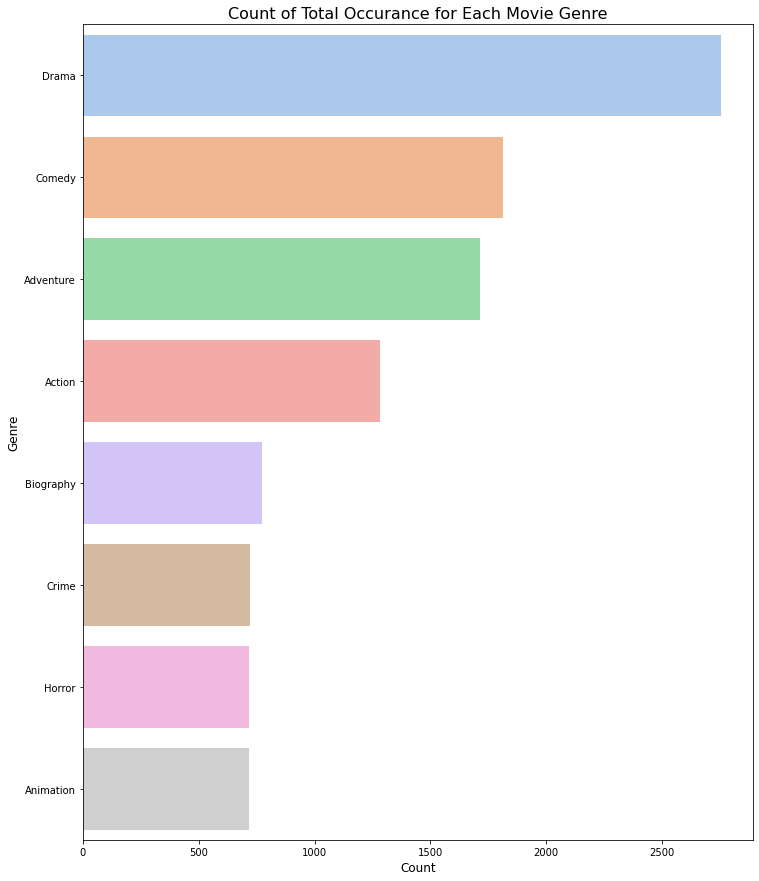

In [ ]:
#source for saving image as png
#png was used in image for powerpoint:
#https://stackoverflow.com/questions/19576317/matplotlib-
#savefig-does-not-save-axes

#source for image:
#https://stackoverflow.com/questions/19576317/
#matplotlib-savefig-does-not-save-axes

g = all_genres_df.nlargest(columns="Count", n = 50) 
fig = plt.figure(figsize=(15,10))
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre", color = 'blue', palette = 'pastel')
ax.set_title('Count of Total Occurance for Each Movie Genre', fontsize=16)
ax.set_ylabel('Genre', fontsize=12)
ax.set_xlabel('Count', fontsize =12)
plt.savefig('filename.jpg',bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
#removing the \nMetascore from the metascore column
#source for new_words code:
#https://stackoverflow.com/questions/29771168/
#how-to-remove-words-from-a-list-in-python

clean_metascore = []

for row in movies_df['metascore']:
    row = str(row).split()
    new_words = list(filter(lambda w: w not in 'Metascore', row))
    clean_metascore.append(new_words)

In [ ]:
movies_df['new_metascore'] = clean_metascore

In [ ]:
movies_df.head(n=10)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep,new_metascore
0,Thor: Love and Thunder,2022,PG-13,118,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",[57]
1,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"[Adventure, Action, Fantasy]","[Adventure, Action]",[83]
2,DC League of Super-Pets,2022,PG,105,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"[Adventure, Action, Animation]","[Adventure, Action, Animation]",[56]
3,Pinocchio(I),2022,PG,105,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",[38]
4,The Greatest Beer Run Ever,2022,R,126,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",[39]
5,Everything Everywhere All at Once,2022,R,139,"Action, Adventure, Comedy",8.1,81 \n Metascore,An aging Chinese immigrant is swept up in an i...,"[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",[81]
6,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178,"Action, Adventure, Drama",8.8,92 \n Metascore,A meek Hobbit from the Shire and eight compani...,"[Adventure, Action, Drama]","[Adventure, Action, Drama]",[92]
7,Jurassic World Dominion,2022,PG-13,147,"Action, Adventure, Sci-Fi",5.7,38 \n Metascore,Four years after the destruction of Isla Nubla...,"[Adventure, Action, Sci-Fi]","[Adventure, Action]",[38]
8,Rogue One: A Star Wars Story,2016,PG-13,133,"Action, Adventure, Sci-Fi",7.8,65 \n Metascore,"In a time of conflict, a group of unlikely her...","[Adventure, Action, Sci-Fi]","[Adventure, Action]",[65]
9,Prey(I),2022,R,99,"Action, Adventure, Drama",7.2,71 \n Metascore,"Naru, a skilled warrior of the Comanche Nation...","[Adventure, Action, Drama]","[Adventure, Action, Drama]",[71]


In [ ]:
#removing brackets in new metascore
movies_df['new_metascore'] = movies_df['new_metascore'].str[0]

In [ ]:
movies_df.head(10)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep,new_metascore
0,Thor: Love and Thunder,2022,PG-13,118,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",57
1,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"[Adventure, Action, Fantasy]","[Adventure, Action]",83
2,DC League of Super-Pets,2022,PG,105,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"[Adventure, Action, Animation]","[Adventure, Action, Animation]",56
3,Pinocchio(I),2022,PG,105,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",38
4,The Greatest Beer Run Ever,2022,R,126,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",39
5,Everything Everywhere All at Once,2022,R,139,"Action, Adventure, Comedy",8.1,81 \n Metascore,An aging Chinese immigrant is swept up in an i...,"[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",81
6,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178,"Action, Adventure, Drama",8.8,92 \n Metascore,A meek Hobbit from the Shire and eight compani...,"[Adventure, Action, Drama]","[Adventure, Action, Drama]",92
7,Jurassic World Dominion,2022,PG-13,147,"Action, Adventure, Sci-Fi",5.7,38 \n Metascore,Four years after the destruction of Isla Nubla...,"[Adventure, Action, Sci-Fi]","[Adventure, Action]",38
8,Rogue One: A Star Wars Story,2016,PG-13,133,"Action, Adventure, Sci-Fi",7.8,65 \n Metascore,"In a time of conflict, a group of unlikely her...","[Adventure, Action, Sci-Fi]","[Adventure, Action]",65
9,Prey(I),2022,R,99,"Action, Adventure, Drama",7.2,71 \n Metascore,"Naru, a skilled warrior of the Comanche Nation...","[Adventure, Action, Drama]","[Adventure, Action, Drama]",71


In [ ]:
#Tokenize description
movies_df['clean_description'] = movies_df['description'].apply(clean_text)

In [ ]:
movies_df.sample(n=5)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep,new_metascore,clean_description
5237,Vertigo,1958,PG,128,MysteryRomanceThriller,8.3,100,A former San Francisco police detective juggle...,"[Mystery, Romance, Thriller]",[],100,"[former, san, francisco, police, detective, ju..."
416,Unforgiven,1992,R,130,"Drama, Western",8.2,85 \n Metascore,Retired Old West gunslinger William Munny relu...,"[Drama, Western]",[Drama],85,"[retired, old, west, gunslinger, william, munn..."
3074,The Long Riders,1980,R,100,"Biography, Crime, Western",6.9,64 \n Metascore,"The origins, exploits and the ultimate fate of...","[Biography, Crime, Western]","[Biography, Crime]",64,"[origins, exploits, ultimate, fate, jesse, jam..."
2385,The Invisible Man(I),2020,R,124,"Drama, Horror, Mystery",7.1,72 \n Metascore,When Cecilia's abusive ex takes his own life a...,"[Drama, Horror, Mystery]","[Drama, Horror]",72,"[cecilia's, abusive, ex, takes, life, leaves, ..."
2618,Robin Hood,1973,G,83,"Animation, Adventure, Comedy",7.5,57 \n Metascore,The story of the legendary British outlaw is p...,"[Adventure, Animation, Comedy]","[Adventure, Animation, Comedy]",57,"[story, legendary, british, outlaw, portrayed,..."


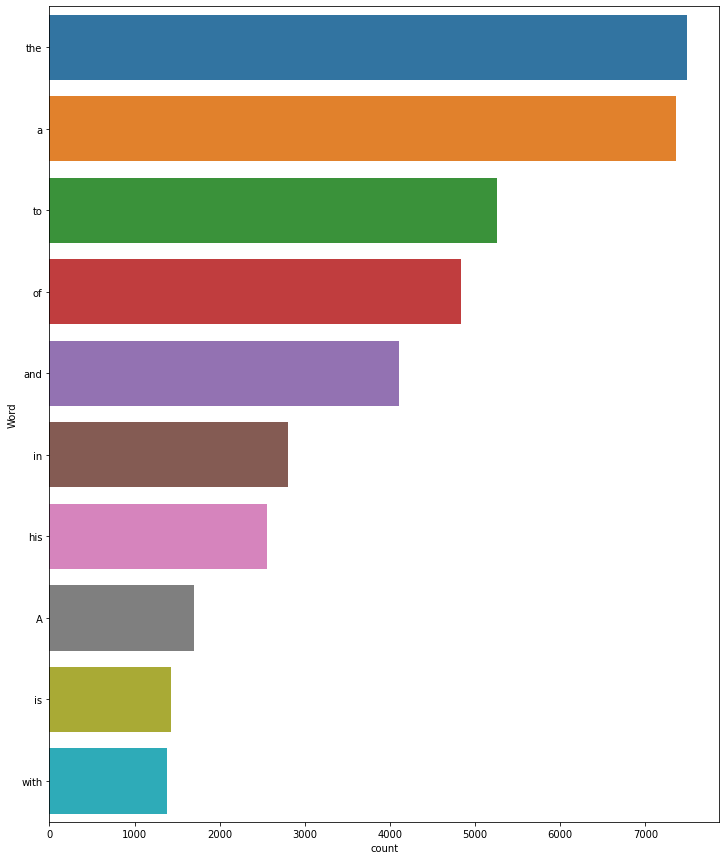

In [ ]:
# print 10 most frequent words 
#for description before removing stopwards
#bar graph displays that stopwards were prominant in our descriptions
freq_words(movies_df['description'], 10)

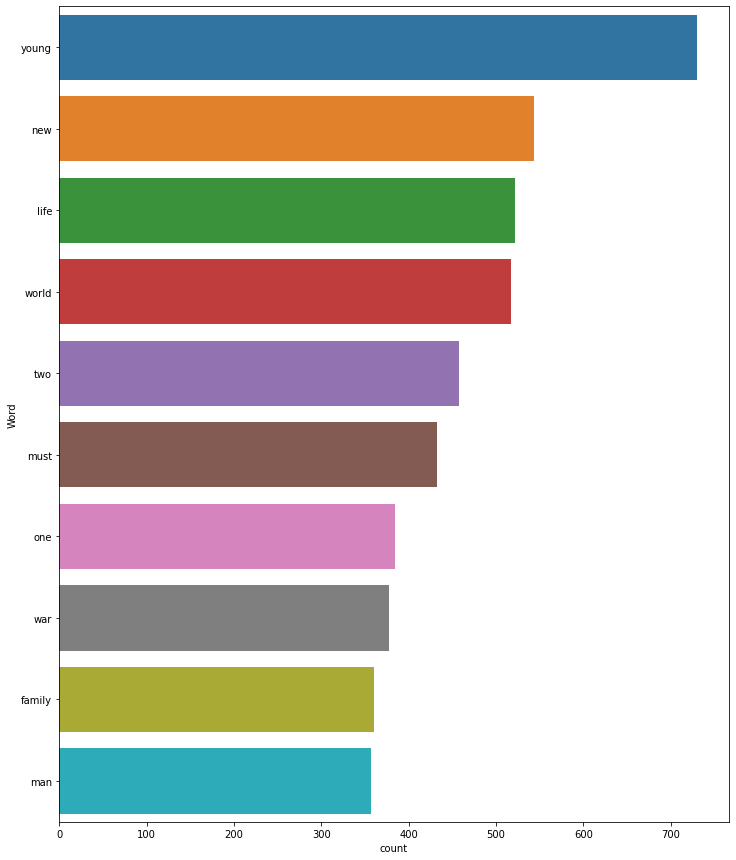

In [ ]:
# print 10 most frequent words 
#for description after removing stopwords
temp_clean_description = []
for row in movies_df['clean_description']:
    result = " ".join(str(x) for x in row)
    temp_clean_description.append(result)

freq_words(temp_clean_description, 10)


### Descriptive Statistics

In [ ]:
# We need to transform the lyrics to lists of tokens for descriptive statistics
token_df = movies_df['clean_description']
token_df_2 = list(flatten(token_df))

In [ ]:
#Shows that we have 11,918 unique tokens, or words, in our 
#descriptions
descriptive_stats(token_df_2)

There are 89993 tokens in the data.
There are 11918 unique tokens in the data.
There are 573189 characters in the data.
The lexical diversity is 0.13243252252953008.
[('young', 730), ('new', 543), ('life', 522), ('world', 517), ('two', 458)]


[89993, 11918, 573189, 0.13243252252953008]

Word Clouds

In [ ]:
#Will split genres to separate columns for movies
#source: https://stackoverflow.com/questions/62567406/
#pandas-check-if-a-substring-exists-in-another-column-
#then-create-a-new-column-w

adventure = {"Adventure":"adventure"}
action = {"Action":"action"}
animation = {"Animation":"animation"}
biography = {"Biography":"biography"}
comedy = {"Comedy":"comedy"}
crime = {"Crime":"crime"}
drama = {"Drama":"drama"}
horror = {"Horror":"horror"}

movies_df["Adventure"] = movies_df["genres_to_keep"].map(lambda x: 
                                                         check_desc(x, adventure))
movies_df["Action"] = movies_df["genres_to_keep"].map(lambda x: 
                                                      check_desc(x, action))
movies_df["Animation"] = movies_df["genres_to_keep"].map(lambda x: 
                                                         check_desc(x, animation))
movies_df["Biography"] = movies_df["genres_to_keep"].map(lambda x: 
                                                         check_desc(x, biography))
movies_df["Comedy"] = movies_df["genres_to_keep"].map(lambda x: 
                                                      check_desc(x, comedy))
movies_df["Crime"] = movies_df["genres_to_keep"].map(lambda x: 
                                                     check_desc(x, crime))
movies_df["Drama"] = movies_df["genres_to_keep"].map(lambda x: 
                                                     check_desc(x, drama))
movies_df["Horror"] = movies_df["genres_to_keep"].map(lambda x: 
                                                      check_desc(x, horror))


In [ ]:
#checking to make sure new columns were added
movies_df.columns

Index(['title', 'year', 'advisory', 'movie_length', 'genre', 'rating',
       'metascore', 'description', 'sep_genre', 'genres_to_keep',
       'new_metascore', 'clean_description', 'Adventure', 'Action',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Horror'],
      dtype='object')

In [ ]:
#checking that data was separated into the correct columns
movies_df.head(10)

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep,new_metascore,clean_description,Adventure,Action,Animation,Biography,Comedy,Crime,Drama,Horror
0,Thor: Love and Thunder,2022,PG-13,118,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",57,"[thor, enlists, help, valkyrie, korg, ex-girlf...",adventure,action,,,comedy,,,
1,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"[Adventure, Action, Fantasy]","[Adventure, Action]",83,"[paraplegic, marine, dispatched, moon, pandora...",adventure,action,,,,,,
2,DC League of Super-Pets,2022,PG,105,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"[Adventure, Action, Animation]","[Adventure, Action, Animation]",56,"[krypto, super-dog, superman, inseparable, bes...",adventure,action,animation,,,,,
3,Pinocchio(I),2022,PG,105,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",38,"[puppet, brought, life, fairy, assigns, lead, ...",adventure,,,,comedy,,drama,
4,The Greatest Beer Run Ever,2022,R,126,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",39,"[man's, story, leaving, new, york, bring, beer...",adventure,,,,comedy,,drama,
5,Everything Everywhere All at Once,2022,R,139,"Action, Adventure, Comedy",8.1,81 \n Metascore,An aging Chinese immigrant is swept up in an i...,"[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",81,"[aging, chinese, immigrant, swept, insane, adv...",adventure,action,,,comedy,,,
6,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178,"Action, Adventure, Drama",8.8,92 \n Metascore,A meek Hobbit from the Shire and eight compani...,"[Adventure, Action, Drama]","[Adventure, Action, Drama]",92,"[meek, hobbit, shire, eight, companions, set, ...",adventure,action,,,,,drama,
7,Jurassic World Dominion,2022,PG-13,147,"Action, Adventure, Sci-Fi",5.7,38 \n Metascore,Four years after the destruction of Isla Nubla...,"[Adventure, Action, Sci-Fi]","[Adventure, Action]",38,"[four, years, destruction, isla, nublar, biosy...",adventure,action,,,,,,
8,Rogue One: A Star Wars Story,2016,PG-13,133,"Action, Adventure, Sci-Fi",7.8,65 \n Metascore,"In a time of conflict, a group of unlikely her...","[Adventure, Action, Sci-Fi]","[Adventure, Action]",65,"[time, conflict, group, unlikely, heroes, band...",adventure,action,,,,,,
9,Prey(I),2022,R,99,"Action, Adventure, Drama",7.2,71 \n Metascore,"Naru, a skilled warrior of the Comanche Nation...","[Adventure, Action, Drama]","[Adventure, Action, Drama]",71,"[naru, skilled, warrior, comanche, nation, fig...",adventure,action,,,,,drama,


In [ ]:
#word cloud for adventure
adventure_cloud = movies_df.loc[movies_df['Adventure'] == 'adventure']
adventure_cloud.head()

,title,year,advisory,movie_length,genre,rating,metascore,description,sep_genre,genres_to_keep,new_metascore,clean_description,Adventure,Action,Animation,Biography,Comedy,Crime,Drama,Horror
0,Thor: Love and Thunder,2022,PG-13,118,"Action, Adventure, Comedy",6.4,57 \n Metascore,"Thor enlists the help of Valkyrie, Korg and ex...","[Adventure, Action, Comedy]","[Adventure, Action, Comedy]",57,"[thor, enlists, help, valkyrie, korg, ex-girlf...",adventure,action,,,comedy,,,
1,Avatar,2009,PG-13,162,"Action, Adventure, Fantasy",7.8,83 \n Metascore,A paraplegic Marine dispatched to the moon Pan...,"[Adventure, Action, Fantasy]","[Adventure, Action]",83,"[paraplegic, marine, dispatched, moon, pandora...",adventure,action,,,,,,
2,DC League of Super-Pets,2022,PG,105,"Animation, Action, Adventure",7.4,56 \n Metascore,Krypto the Super-Dog and Superman are insepara...,"[Adventure, Action, Animation]","[Adventure, Action, Animation]",56,"[krypto, super-dog, superman, inseparable, bes...",adventure,action,animation,,,,,
3,Pinocchio(I),2022,PG,105,"Adventure, Comedy, Drama",5.1,38 \n Metascore,"A puppet is brought to life by a fairy, who as...","[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",38,"[puppet, brought, life, fairy, assigns, lead, ...",adventure,,,,comedy,,drama,
4,The Greatest Beer Run Ever,2022,R,126,"Adventure, Comedy, Drama",6.8,39 \n Metascore,A man's story of leaving New York in 1967 to b...,"[Adventure, Comedy, Drama]","[Adventure, Comedy, Drama]",39,"[man's, story, leaving, new, york, bring, beer...",adventure,,,,comedy,,drama,


In [ ]:
adventure_count_words = count_words(adventure_cloud)

1


In [ ]:
adventure_count_words.head()

,freq
token,
world,266
young,249
must,225
new,222
find,141


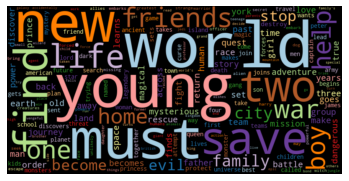

In [ ]:
wordcloud(adventure_count_words['freq'])

1


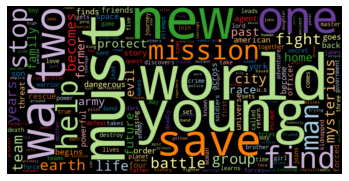

In [ ]:
#for action
action_cloud = movies_df.loc[movies_df['Action'] == 'action']
action_count_words = count_words(action_cloud)
action_count_words.head()
wordcloud(action_count_words['freq'])

1


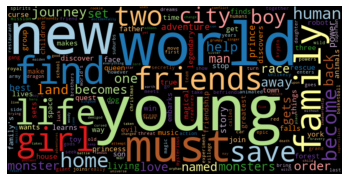

In [ ]:
#for animation
animation_cloud = movies_df.loc[movies_df['Animation'] == 'animation']
animation_count_words = count_words(animation_cloud)
animation_count_words.head()
wordcloud(animation_count_words['freq'])

1


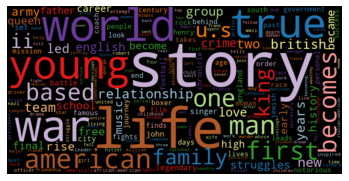

In [ ]:
#for biography
biography_cloud = movies_df.loc[movies_df['Biography'] == 'biography']
biography_count_words = count_words(biography_cloud)
biography_count_words.head()
wordcloud(biography_count_words['freq'])

1


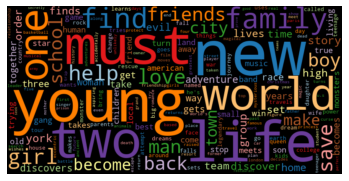

In [ ]:
#for comedy
comedy_cloud = movies_df.loc[movies_df['Comedy'] == 'comedy']
comedy_count_words = count_words(comedy_cloud)
comedy_count_words.head()
wordcloud(comedy_count_words['freq'])

1


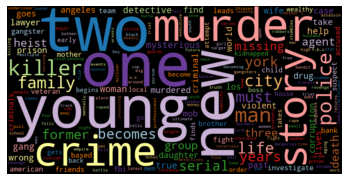

In [ ]:
#for crime
crime_cloud = movies_df.loc[movies_df['Crime'] == 'crime']
crime_count_words = count_words(crime_cloud)
crime_count_words.head()
wordcloud(crime_count_words['freq'])

1


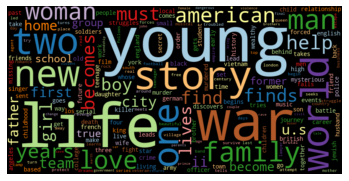

In [ ]:
#for drama
drama_cloud = movies_df.loc[movies_df['Drama'] == 'drama']
drama_count_words = count_words(drama_cloud)
drama_count_words.head()
wordcloud(drama_count_words['freq'])

1


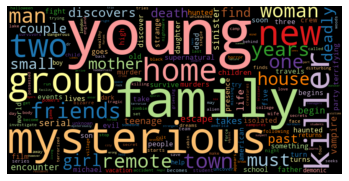

In [ ]:
#for horror
horror_cloud = movies_df.loc[movies_df['Horror'] == 'horror']
horror_count_words = count_words(horror_cloud)
horror_count_words.head()
wordcloud(horror_count_words['freq'])

### Topic Modeling

In [ ]:
#Transforming descriptions column into count vectors. Holding the count of each token
stop_words = set(stopwords.words("english"))
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(movies_df["description"])
count_text_vectors.shape

(5386, 3596)

In [ ]:
#Transforming descriptions column into vectors. Holds the weight
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(movies_df["description"])
tfidf_text_vectors.shape

(5386, 3596)

#### Fitting a Non-Negative Matrix Factorization Model (NMF)

In [ ]:
#Creating NMF model with 8 topics
nmf_text_model = NMF(n_components=8, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
#Displaying topics
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
 must (3.41)
 stop (1.13)
 save (1.00)
 order (0.82)
 evil (0.78)

Topic 01
 war (5.13)
 world (4.55)
 ii (3.07)
 american (1.38)
 german (1.11)

Topic 02
 young (5.71)
 woman (3.28)
 man (1.73)
 love (1.10)
 boy (1.06)

Topic 03
 life (6.52)
 story (0.97)
 real (0.83)
 career (0.75)
 become (0.73)

Topic 04
 old (4.99)
 year (4.72)
 story (2.13)
 one (1.57)
 greatest (1.21)

Topic 05
 new (5.82)
 york (3.65)
 city (3.38)
 called (0.68)
 protect (0.54)

Topic 06
 two (1.99)
 family (1.23)
 friends (1.04)
 town (0.88)
 find (0.87)

Topic 07
 school (5.45)
 high (5.00)
 team (1.23)
 student (1.11)
 coach (1.07)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


For Topic00, Topic01, Topic04, Topic05 the percentages drop quickly, implying that these topics are well defined. For certain topics such as topic06, words such as two, family, friends, town, find are irrelevant to clearly defining a genre

#### Fitting a TruncatedSVD Model (LSA)

In [ ]:
#Creating LSA model with 8 topics
svd_text_model = TruncatedSVD(n_components = 8, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [ ]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
 young (0.80)
 world (0.66)
 life (0.59)
 new (0.57)
 man (0.47)

Topic 01
 war (28.64)
 world (27.14)
 ii (17.92)
 german (6.36)
 american (6.03)

Topic 02
 young (13.48)
 woman (8.34)
 man (3.25)
 boy (2.05)
 war (1.98)

Topic 03
 life (47.50)
 story (17.20)
 become (11.29)
 woman (7.93)
 real (7.42)

Topic 04
 old (11.52)
 year (11.14)
 one (6.64)
 story (5.88)
 two (4.66)

Topic 05
 year (4.39)
 old (4.34)
 new (4.28)
 world (3.82)
 york (3.09)

Topic 06
 school (55.93)
 high (53.46)
 story (26.84)
 true (18.27)
 team (16.43)

Topic 07
 story (42.33)
 one (35.31)
 man (30.87)
 new (19.74)
 true (17.76)


For Topic01, Topic02, Topic04, Topic06, Topic07 the percentages drop quickly, implying that these topics are well defined. For some of the topics that are well defined, when looking more closely at the words, it is clear that the words are too generic to be tied to one genre. For example, Topic02, has words such as young, man, women, and war, which can fall under several genres. For certain topics such as topic05, words such as year, old, new, world, and york are irrelevant to clearly defining a genre.

#### Fitting a Latent Dirichlet Allocation Model (LDA)

In [ ]:
# Creating multiple LDA model with topics between 2-20
n_samples = 0.7
n_features = 1000
n_top_words = 20


for i in range(5,50,3):
    n_topics = i

    print("Fitting LDA models with tf features, "
          "n_samples=%d, n_topics=%d "
          % (n_samples, n_topics))

    lda = LatentDirichletAllocation(n_components=n_topics,
                                     random_state=314)
    t0 = time.time()
    
    #lda.fit(count_text_vectors)
    
    W_lda_text_matrix = lda.fit_transform(count_text_vectors)
    H_lda_text_matrix = lda.components_
    
    gamma = lda.transform(count_text_vectors)
    perplexity = lda.perplexity(count_text_vectors, gamma.any())


    #Getting the perplexity of the model to see which model performs best
    print('Perplexity: ', perplexity)

    print("done in %0.3fs." % (time.time() - t0))
    print('\n')

Fitting LDA models with tf features, n_samples=0, n_topics=5 
Perplexity:  1685.227205838562
done in 12.340s.


Fitting LDA models with tf features, n_samples=0, n_topics=8 
Perplexity:  1517.26169887416
done in 10.045s.


Fitting LDA models with tf features, n_samples=0, n_topics=11 
Perplexity:  1372.6701902604395
done in 9.636s.


Fitting LDA models with tf features, n_samples=0, n_topics=14 
Perplexity:  1267.0369451604142
done in 9.352s.


Fitting LDA models with tf features, n_samples=0, n_topics=17 
Perplexity:  1190.4969603370482
done in 9.290s.


Fitting LDA models with tf features, n_samples=0, n_topics=20 
Perplexity:  1123.9121795878827
done in 9.149s.


Fitting LDA models with tf features, n_samples=0, n_topics=23 
Perplexity:  1063.237660239911
done in 9.266s.


Fitting LDA models with tf features, n_samples=0, n_topics=26 
Perplexity:  1008.9895288538065
done in 11.142s.


Fitting LDA models with tf features, n_samples=0, n_topics=29 
Perplexity:  966.7958316918541
done 

From observing, as topics are increased there is a decrease in the perplexity. This means that the selected model with the lowest perplexity is not ideal.

### Applying GridSearch

In [ ]:
#Using GridSearch to find best parameter

# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(count_text_vectors)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]})

In [ ]:
#GridSearch Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(count_text_vectors))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 2}
Best Log Likelihood Score:  -125787.78062622555
Model Perplexity:  2098.272722264734


According to GridSearch, the best model is with parameters {'learning_decay': 0.9, 'n_components': 2}

#### Comparing Model Performance Scores

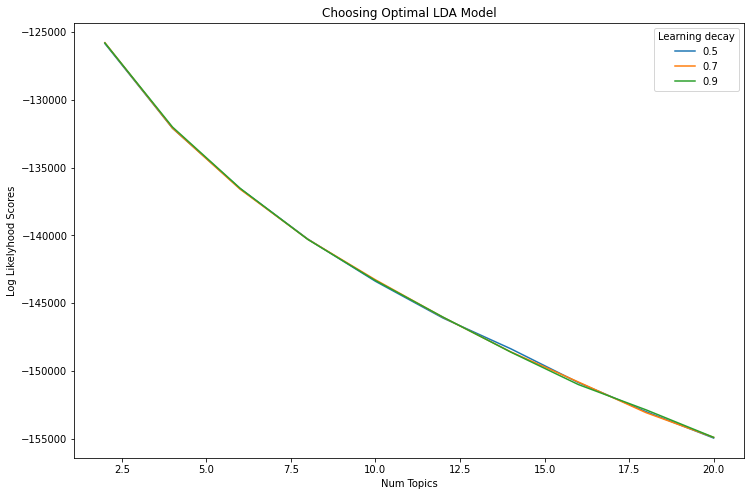

In [ ]:
#Get Log Likelihoods from Grid Searchg Output
n_topics = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])
                                         if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])
                                         if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params'])
                                         if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

There is a big decrease in log likelihood scores as num topics increases, because of this GridSearch chose num_topics of 2 for our best model.

#### Creating Best LDA model

In [ ]:
#Creating LDA model with 2 topics
lda_text_model = LatentDirichletAllocation(n_components = 2, learning_decay= 0.7, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

#### Looking at the scores and perplexity of our model

In [ ]:
# Log Likelihood: Typically the higher the better
print("Log Likelihood: ", lda_text_model.score(count_text_vectors))

Log Likelihood:  -583409.2241801127


In [ ]:
# Perplexity: Typically the lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_text_model.perplexity(count_text_vectors))

Perplexity:  2106.4808228309867


In [ ]:
#displaying topics
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
 new (1.24)
 life (0.91)
 family (0.75)
 city (0.61)
 must (0.55)

Topic 01
 young (1.34)
 world (1.07)
 war (0.92)
 two (0.69)
 woman (0.63)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In both of our topics, there are no quick drop in percentages and the words to define each topic are very generic.

### Visualizing LDA Results

In [ ]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors,
                                       count_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


The topics are well pronounced given that the term frequency does not decrease quickly for both and the PC bubbles are far apart. However, the prominent words for each topic do not help in separating genres. 

Conclusion on Topic Modeling

NMF:
Negative Matrix Factorization (NMF). We set our numnber of topics to 8, given we are classifying eight genres. This is because we wanted to see how our different topics can apply to the specific genres (Adveture, Animation, Action, Biography, Crime, Drama and Horror). For example, Topic 00 can align with the genre horror because of the word distribution (Must, Stop, Save, Order, Evil) and so forth. The percentage of the words within a topic are a good indication for the quality of the topic model. If the percentage within a topic is rapidly decreasing, the topic is well defined, but the words within the topic can sometimes appear too vague and might apply to multiple genres. A prime example of this, once again, is topic 00 because of how the percentages are decreasing drastically. We can see this in most of our topics except topic03 aand topic06.

LSA:
For LSA, we applied the same parameters as NMF. We can immediately see that topic00 and topic05 are not really relevant and the distribution of the words in these are very broad and do not tie in a specific genre. We can also see that Topic01 is also very similar to NMF topic01. Both use the word distributions of (War, World, ii, German, American) but LSA topic01 is more meaningful because of the percentage decrease.

LDA:
Our approach in LDA was very different. Instead of manually inserting the parameters, we decided to use a for loop to create multiple LDA models with their perplexity. We were aiming to select the model with the lowest perplexity because a lower perplexity indicates a better generalization model performance. This method was not very pleasing because we noticed that when we increased the number of topics, perplexity tends to decrease. The next method, GridSearch, was then used to find the best parameters between the topics 2-20. According to GridSearch, our best model was with only 2 topics. These 2 topics did not give us relevant information, as can be seen in our display.

### Naive Bayes Modeling

In [ ]:
#Instantiate the naive bayes classifier
## We chose the Naive Bayes model it assumes independence of features and each
# feature is an independent movie.

nb_classifier = MultinomialNB()

In [ ]:
# convert words in to a vector to begin modeling 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer=clean_text).fit(movies_df['description'])

In [ ]:
# getting word counts
cv.vocabulary_

{'thor': 10625,
 'enlists': 3463,
 'help': 4838,
 'valkyrie': 11262,
 'korg': 5846,
 'ex-girlfriend': 3618,
 'jane': 5572,
 'foster': 4110,
 'fight': 3928,
 'gorr': 4449,
 'god': 4406,
 'butcher': 1416,
 'intends': 5409,
 'make': 6341,
 'gods': 4412,
 'extinct': 3724,
 'paraplegic': 7620,
 'marine': 6430,
 'dispatched': 2959,
 'moon': 6846,
 'pandora': 7605,
 'unique': 11124,
 'mission': 6762,
 'becomes': 917,
 'torn': 10749,
 'following': 4050,
 'orders': 7433,
 'protecting': 8270,
 'world': 11773,
 'feels': 3879,
 'home': 4984,
 'krypto': 5858,
 'super-dog': 10258,
 'superman': 10277,
 'inseparable': 5366,
 'best': 993,
 'friends': 4188,
 'sharing': 9507,
 'superpowers': 10282,
 'fighting': 3932,
 'crime': 2371,
 'side': 9591,
 'metropolis': 6649,
 'however': 5073,
 'must': 6982,
 'master': 6477,
 'powers': 8078,
 'rescue': 8761,
 'kidnapped': 5775,
 'puppet': 8342,
 'brought': 1316,
 'life': 6063,
 'fairy': 3772,
 'assigns': 623,
 'lead': 5976,
 'virtuous': 11402,
 'order': 7430,
 '

In [ ]:
# Instantiating the transform count vectors
description_cv  = cv.transform(movies_df['description'])

In [ ]:
# Count of the vector placements
print(description_cv)

  (0, 1416)	1
  (0, 3463)	1
  (0, 3618)	1
  (0, 3724)	1
  (0, 3928)	1
  (0, 4110)	1
  (0, 4406)	1
  (0, 4412)	1
  (0, 4449)	1
  (0, 4838)	1
  (0, 5409)	1
  (0, 5572)	1
  (0, 5846)	1
  (0, 6341)	1
  (0, 10625)	1
  (0, 11262)	1
  (1, 917)	1
  (1, 2959)	1
  (1, 3879)	1
  (1, 4050)	1
  (1, 4984)	1
  (1, 6430)	1
  (1, 6762)	1
  (1, 6846)	1
  (1, 7433)	1
  :	:
  (5384, 5902)	3
  (5384, 6317)	3
  (5384, 6341)	3
  (5384, 8073)	3
  (5384, 8074)	3
  (5384, 10126)	3
  (5384, 10931)	1
  (5384, 10934)	2
  (5384, 11218)	3
  (5384, 11354)	3
  (5384, 11422)	3
  (5384, 11698)	3
  (5385, 186)	3
  (5385, 928)	3
  (5385, 1209)	3
  (5385, 2787)	1
  (5385, 2788)	2
  (5385, 4348)	3
  (5385, 4456)	3
  (5385, 7496)	3
  (5385, 7618)	3
  (5385, 8960)	3
  (5385, 9860)	3
  (5385, 11496)	3
  (5385, 11872)	3


In [ ]:
# Turning X variables to an array 
X = description_cv.toarray()

In [ ]:
# Viewing the array 
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Fit the tfidf transformer
tfidf_transformer=TfidfTransformer().fit(description_cv)
print(TfidfTransformer)

# getting the most significant words by percentage
desc_tfidf = tfidf_transformer.transform(description_cv)
print(desc_tfidf)
print(desc_tfidf.shape)

<class 'sklearn.feature_extraction.text.TfidfTransformer'>
  (0, 11262)	0.2853012848349029
  (0, 10625)	0.25114966967621943
  (0, 6341)	0.17417812254890927
  (0, 5846)	0.2853012848349029
  (0, 5572)	0.2685025503427964
  (0, 5409)	0.2732751909597645
  (0, 4838)	0.14861482313201832
  (0, 4449)	0.2853012848349029
  (0, 4412)	0.23951851586692177
  (0, 4406)	0.24603500049425178
  (0, 4110)	0.25712046870724387
  (0, 3928)	0.17292389869231237
  (0, 3724)	0.2642927829696356
  (0, 3618)	0.2732751909597645
  (0, 3463)	0.23951851586692177
  (0, 1416)	0.2787848002075729
  (1, 11773)	0.13488318931018436
  (1, 11124)	0.25217599329866985
  (1, 10749)	0.2461150361517731
  (1, 8270)	0.2733684700164433
  (1, 7620)	0.3226250978547264
  (1, 7605)	0.33393629489268045
  (1, 7433)	0.2762822764555097
  (1, 6846)	0.25559714089151603
  (1, 6762)	0.19808084026198672
  :	:
  (5384, 10934)	0.24059586245154255
  (5384, 10931)	0.06175181697599041
  (5384, 10126)	0.2295451117474888
  (5384, 8074)	0.28197495779798337


In [ ]:
import numpy as np

In [ ]:
# Setting up multilabel classification to handle multiple y variables
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(movies_df['genres_to_keep'])

y = mlb.transform(movies_df['genres_to_keep'])

In [ ]:
# View th y variable
y

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
# fit the multinomial naive bayes model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [ ]:
print(X)
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [ ]:
# support vector classification
movies_df.columns

Index(['title', 'year', 'advisory', 'movie_length', 'genre', 'rating',
       'metascore', 'description', 'sep_genre', 'genres_to_keep',
       'new_metascore', 'clean_description', 'Adventure', 'Action',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Horror'],
      dtype='object')

In [ ]:

tfidf_vectorizer = TfidfVectorizer(max_df=.8, max_features=10000)

In [ ]:
#Split the data into training and testing data. 
# 80% for training and 20% for testing.
xtrain, xtest, ytrain, ytest = train_test_split(movies_df['description'],y, test_size=0.2, random_state=42)

In [ ]:
# Create vectors to train the model 
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

Logistic Regression Model

In [ ]:
# initialize the logistic regression model 
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
ytest

array([[0, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [ ]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(4308,)
(1078,)
(4308, 8)
(1078, 8)


In [ ]:
# Fit the logistic regression model 
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
# Create the y predictions
y_pred = clf.predict(xtest_tfidf)

In [ ]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#Get the inverse of the multilabel binarization
mlb.inverse_transform(y_pred)

[(),
 (),
 ('Drama',),
 ('Comedy', 'Crime', 'Drama'),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 ('Adventure',),
 (),
 ('Adventure',),
 ('Drama',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 ('Adventure', 'Animation'),
 (),
 ('Adventure', 'Animation', 'Comedy'),
 ('Adventure', 'Comedy'),
 ('Comedy', 'Drama'),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Crime', 'Drama'),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Action', 'Adventure'),
 ('Drama',),
 ('Crime', 'Drama'),
 ('Crime', 'Drama'),
 ('Action', 'Drama'),
 ('Action', 'Adventure', 'Comedy'),
 ('Action', 'Adventure', 'Drama'),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 ('Animation', 'Comedy'),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Comedy', 'Drama'),
 ('Horror',),
 ('Drama',),
 ('Action', 'Adventure', 'Comedy'),
 ('Drama',),
 ('Drama',),
 ('Action', 'Adventure', 'Drama'),
 ('Drama',),
 (),
 ('Action', 'Adventure'),
 ('Drama',),
 (),

In [ ]:
# Get the f1-score for the logistic regression model
f1_score(ytest, y_pred, average="micro")

0.6760059612518629

In [ ]:
# the accuracy for the logistic regression model
accuracy_score
print('Accuracy Score', accuracy_score(xtest, y_pred).astype("int32"))

ValueError: ignored

In [ ]:
## Naive bayes  model 
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
xtrain_tf = tfidf.fit_transform(xtest)

In [ ]:
print(xtrain_tfidf.shape)
print(ytrain.shape)

In [ ]:
print(xtrain.shape)

In [ ]:
ytrain

In [ ]:
# creating features to train the test set 
xtrain_tf =tfidf.transform(xtest)

In [ ]:
# Create predictions for the Naive Bayes model 
y_pred = mod1.predict(xtrain_tf)

In [ ]:
# The accuracy score for the naive bayes model 
accuracy_score,
print('Accuracy Score', accuracy_score(xtest, y_pred))

In conclusion we would choose the multinomial naive bayes model for its high accuracy (97%) in comparison to the logistic regression model (37%). Accuracy was a choice of measure because we only care about accurately classifying the correct genres.